In [43]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Input, Dense, ReLU
from keras import optimizers, layers
from tensorflow import math
import warnings
warnings.filterwarnings('ignore')

In [44]:
import statistics

rain = pd.read_csv("./Data/Rainfall.csv")

lpa = statistics.mean(list(rain['Jun-Sep'][12:41]))
rain_fall_data = list(rain['Jun-Sep'])

In [45]:
import glob

uwnd_path = "./Data/uwnd/*"

uwnd_months = []
for i in glob.glob(uwnd_path):
  uwnd_months.append(i)
  

In [46]:
for month in range(5):
    month_path = uwnd_months[month]
    month_data = pd.read_csv(month_path, header=[0, 1], index_col=0)
    data = np.array(month_data[:67])

## Auto-Encoders (SLP or UWND)

- 324 - 97 - 324

In [47]:
def get_model_324(n_inputs=324):
    visible = Input(shape=(n_inputs,))
    e = Dense(n_inputs)(visible)
    e = ReLU()(e)
    bottleneck = Dense(97)(e)
    output = Dense(n_inputs, activation='linear')(bottleneck)
    model = Model(inputs=visible, outputs=output)
    model.compile(optimizer='adam', loss='mse')
    return model

- 97 - 29 - 97

In [48]:
def get_model_97(n_inputs=97):
    visible = Input(shape=(n_inputs,))
    e = Dense(n_inputs)(visible)
    e = ReLU()(e)
    bottleneck = Dense(29)(e)
    output = Dense(n_inputs, activation='linear')(bottleneck)
    model = Model(inputs=visible, outputs=output)
    model.compile(optimizer='adam', loss='mse')
    return model

- 29 - 9 - 29

In [49]:
def get_model_29(n_inputs=29):
    visible = Input(shape=(n_inputs,))
    e = Dense(n_inputs)(visible)
    e = ReLU()(e)
    bottleneck = Dense(9)(e)
    output = Dense(n_inputs, activation='linear')(bottleneck)
    model = Model(inputs=visible, outputs=output)
    model.compile(optimizer='adam', loss='mse')
    return model

#### Final Auto Encoder
- 324 - 97 - 29 - 9 - 29 - 97 - 324

In [50]:
def get_model_final_324(n_inputs=324):
    visible = Input(shape=(n_inputs,))
    e = Dense(n_inputs)(visible)
    e = ReLU()(e)
    e = Dense(97)(e)
    e = ReLU()(e)
    e = Dense(29)(e)
    e = ReLU()(e)
    bottleneck = Dense(9)(e)
    e = Dense(29)(bottleneck)
    e = ReLU()(e)
    e = Dense(97)(e)
    e = ReLU()(e)
    output = Dense(n_inputs, activation='linear')(e)
    model = Model(inputs=visible, outputs=output)
    model.compile(optimizer='adam', loss='mse')
    return model

In [51]:
class Custom_Layer(layers.Layer):
    def __init__(self, weights, bias=False):
        super(Custom_Layer, self).__init__()
        self.w = weights
        if bias:
            self.b = bias

    def call(self, inputs):
        try: return tf.matmul(inputs, self.w) + self.b
        except: return tf.matmul(inputs, self.w)

In [52]:
def predictor(month,mod):
    month_path = uwnd_months[month]
    month_data = pd.read_csv(month_path, header=[0, 1], index_col=0)
    feature = np.array(month_data)
    pred = models[mod](feature)
    pred = pred.numpy()
    return pred

In [53]:
from sklearn.svm import SVR
from scipy.stats import pearsonr
from scipy.stats import spearmanr


def get_top_pred(top,pred_info,w_start,w_end):
    pred_f = pred_info
    cor_list = []
    for i in range(len(pred_f[0])):
        score = []
        for j in range(w_start,w_end):
            score.append(pred_f[j][i])
        corr, _ = pearsonr(rain_fall_data[w_start:w_end],score)
        cor_list.append(corr)
    list1=list(enumerate(cor_list))
    list2=sorted(list1, key=lambda x: x[1],reverse=True)
    top_feature_index = []
    for i in range(top):
        try: index = list2[i][0]
        except: continue
        top_feature_index.append(index)
    predictor = []
    for i in range(len(pred_f)):
        temp = []
        for j in top_feature_index:
            feature = pred_f[i][j]
            temp.append(feature)
        predictor.append(temp)
    return predictor


def get_predictors(months,top,models,w_start,w_end):
    for i in months:
        for mod in range(len(models)):
            y_pred = predictor(i,mod)
            b = get_top_pred(top, y_pred, w_start,w_end)
            try:    pred = np.concatenate((pred,b), axis=1)
            except: pred = np.array(b)
    return pred

def window_solution(months,top):
    reg = SVR(kernel = 'rbf',C=1.0,epsilon=0.45)
    cor_all = [[], []]
    for window in range(20,67):
        score = []
        pred = get_predictors(months,top,models,67-window,67)
        for i in range(10):
            reg.fit(pred[67-window:61+i], rain_fall_data[67-window:61+i])
            score.append(reg.predict([pred[61+i]])[0])
        cor_all[0].append(pearsonr(rain_fall_data[61:71],score)[0])
        cor_all[1].append(spearmanr(rain_fall_data[61:71],score)[0])
    return [min(cor_all[0]), max(cor_all[0])], [min(cor_all[1]), max(cor_all[1])]

def get_best_predictions(months, top, s, e):
    reg = SVR(kernel = 'rbf',C=1.0,epsilon=0.45)
    r_data = rain_fall_data[61:71]
    cor_all = []
    for window in range(20,67):
        score = []
        pred = get_predictors(months,top,models,67-window,67)
        for i in range(61, 71):
            reg.fit(pred[67-window:i], rain_fall_data[67-window:i])
            score.append(reg.predict([pred[i]])[0])
        corr = max(abs(np.array([pearsonr(r_data,score)[0], spearmanr(r_data,score)[0]])))
        if(cor_all == [] or (cor_all != [] and corr > max(abs(np.array(cor_all))))):
            w = reg.predict(pred[s:e])
        cor_all.append(corr)
    return w

In [139]:
model_final = keras.models.load_model("./Data/2 uwnd model (0.8803).h5")

std = []
for i in model_final.layers:
    try: std.append(np.array(math.reduce_std(i.weights[0])) * 2)
    except: std.append([])

final_layers = keras.Sequential([Input(shape=(None, 324))])
for i, layer in enumerate(model_final.layers):
    try:
        temp_layer = []
        for ind, j in enumerate(layer.weights[0]):
            temp_weights = []
            for index, k in enumerate(j):
                if k < std[i]: temp_weights.append(0)
                else:          temp_weights.append(1)  
            temp_layer.append(temp_weights)
        weights = tf.Variable(temp_layer, dtype='float32')
        try: final_layers.add(Custom_Layer(weights, bias=layer.weights[1]))
        except: final_layers.add(Custom_Layer(weights))
    except IndexError: final_layers.add(layer)

final_layers.compile(optimizer='adam', loss='mse')
final_layers.build(input_shape=(None, 324))


final_layers1 = Model(inputs=final_layers.input, outputs=final_layers.layers[3].output)
final_layers1.trainable = False

final_layers2 = Model(inputs=final_layers.input, outputs=final_layers.layers[5].output)
final_layers2.trainable = False

final_layers3 = Model(inputs=final_layers.input, outputs=final_layers.layers[7].output)
final_layers3.trainable = False

In [140]:
months_comb = [[4]]
top = 9
models = [final_layers1, final_layers2, final_layers3]

min_p, max_p = 1, -1
min_s, max_s = 1, -1
best = 0
for month in months_comb:
    for j in range(1,top):
        plcc, srcc = window_solution(month,j)
        print(j, plcc, srcc)
        if min_p > min(plcc): min_p = min(plcc)
        if min_s > min(srcc): min_s = min(srcc)
        if max_p < max(plcc): max_p = max(plcc)
        if max_s < max(srcc): max_s = max(srcc)
        if best <= max(abs(np.array(plcc+srcc))): best, best_top = max(abs(np.array(plcc+srcc))), j
print("\n", [min_p, max_p], [min_s, max_s])

1 [-0.8024632223430104, -0.31648707335878207] [-0.7454545454545454, -0.29696969696969694]
2 [-0.7850756924865965, -0.3173132120045936] [-0.7696969696969697, -0.2727272727272727]
3 [-0.750653882108332, -0.3433071864159212] [-0.8181818181818182, -0.2727272727272727]
4 [-0.7778283909408418, -0.34333147711532763] [-0.8181818181818182, -0.2727272727272727]
5 [-0.7922103751628674, -0.3437112648537013] [-0.8181818181818182, -0.2727272727272727]
6 [-0.8803736537368219, -0.34370874154259184] [-0.8909090909090909, -0.2727272727272727]
7 [-0.8799039016470631, -0.3437068410449703] [-0.8909090909090909, -0.2727272727272727]
8 [-0.8794367237014615, -0.34412185072526813] [-0.8909090909090909, -0.1515151515151515]

 [-0.8803736537368219, -0.31648707335878207] [-0.8909090909090909, -0.1515151515151515]


## Normalizating the predictions

In [117]:
s, e = 61, 71
l = e - s
predictions = get_best_predictions([4], best_top, s, e)
predictions

array([884.69930887, 884.33850924, 884.62646208, 884.30459483,
       884.44644339, 884.78842696, 884.95589272, 884.45892091,
       885.41542701, 884.99554483])

In [118]:
from sklearn.linear_model import LinearRegression

years = np.array([[i] for i in range(1949+s, 1949+e)])
predictions = np.array(predictions).reshape(-1,1)
rain_data = np.array(rain_fall_data[s:e]).reshape(-1,1)

x, y, z = years, predictions, rain_data

lr_1, lr_2 = LinearRegression(), LinearRegression()
lr_1.fit(x, y), lr_2.fit(x, z)

p1_x, p2_x = 1949+s, 1949+e-1
p1_y, p2_y = lr_1.predict([[p1_x], [p2_x]])
p1, p2 = np.array([p1_x, p1_y]), np.array([p2_x, p2_y])

p3_x, p4_x = 1949+s, 1949+e-1
p3_y, p4_y = lr_1.predict([[p3_x], [p4_x]])
p3, p4 = np.array([p3_x, p3_y]), np.array([p4_x, p4_y])

p5 = np.concatenate((x, predictions), axis=1)
p6 = np.concatenate((x, rain_data), axis=1)

d_1 = (np.cross(p2-p1, p1-p5)) / np.linalg.norm(p2-p1)
d_2 = (np.cross(p4-p3, p3-p6)) / np.linalg.norm(p4-p3)

multipliyer = sum(abs(d_2/d_1)) /14

difference = multipliyer * d_1
result = []
for i, j in zip(y, difference):
    result.append(i[0] + j[0])

error = (np.array(result).reshape(-1,1) - rain_data)/rain_data * 100

### Visualization

In [119]:
bestFit_pred = lr_1.predict(x)
bestFit_rain = lr_2.predict(x)

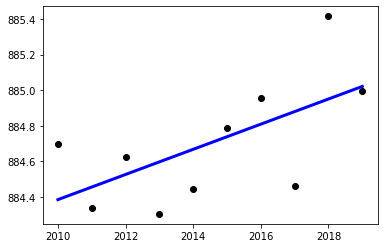

In [120]:
import matplotlib.pyplot as plt

plt.scatter(years, predictions, color="black")
plt.plot(years, bestFit_pred, color="blue", linewidth=3)

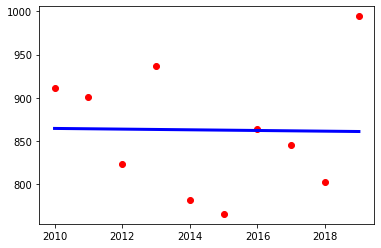

In [121]:
plt.scatter(years, rain_data, color="red")
plt.plot(years, bestFit_rain, color="blue", linewidth=3)

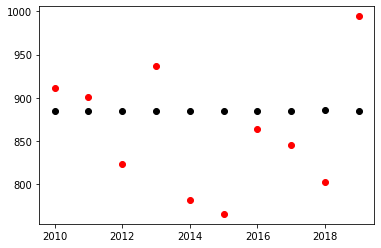

In [122]:
plt.scatter(years, predictions, color="black")
plt.scatter(years, rain_data, color="red")

## Final Predictions

In [127]:
s_p, e_p = 61, 74
l_p = e_p - s_p

predictions_n = get_best_predictions([4], best_top, s_p, e_p)

x_p = np.array(range(1949+s_p, 1949+e_p)).reshape(-1, 1)
predictions_n = np.array(predictions_n).reshape(-1, 1)

p3 = np.concatenate((x_p, predictions_n), axis=1)

d_1 = (np.cross(p2-p1, p1-p3)) / np.linalg.norm(p2-p1)

difference = multipliyer * d_1
result = []
for i, j in zip(predictions_n, difference):
    result.append(i[0] + j[0])

In [128]:
np.concatenate((np.arange(1949+s_p, 1949+e_p-1).reshape(-1, 1), np.array(rain_fall_data[s_p:e_p]).reshape(-1, 1), np.array(result[:-1]).reshape(-1, 1)), axis=1)

# Year        Rainfall Data        Predicton

array([[2010.        ,  911.1       ,  693.13362419],
       [2011.        ,  901.3       ,  955.65265812],
       [2012.        ,  823.9       ,  823.56958257],
       [2013.        ,  937.2       , 1062.40809006],
       [2014.        ,  782.1       , 1019.19258235],
       [2015.        ,  765.8       ,  854.24544197],
       [2016.        ,  864.4       ,  795.44833818],
       [2017.        ,  845.9       , 1140.79376928],
       [2018.        ,  802.7       ,  602.06479527],
       [2019.        ,  994.4       ,  900.52064884],
       [2020.        ,  958.1       , 1350.66419424],
       [2021.        ,  874.6       , 1376.23418357]])

Text(0.5, 1.0, 'Predictions using UWND\n')

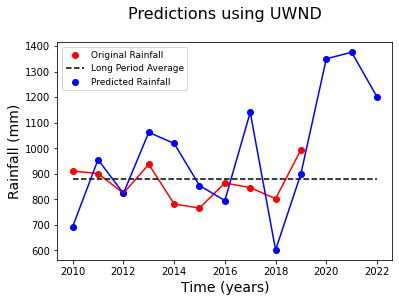

In [143]:
plt.scatter(years, rain_data, color="red", label='Original Rainfall') 
plt.plot(years, rain_data, color="red", linewidth=1.5)          
plt.plot(x_p, np.ones(len(x_p)) * lpa, color="black", linestyle='dashed', label="Long Period Average")
plt.scatter(x_p, result, color="blue", label='Predicted Rainfall')
plt.plot(x_p, result, color="blue", linewidth=1.5)
plt.legend(fontsize="9", loc="upper left")      
plt.xlabel('Time (years)', fontsize=14)
plt.ylabel('Rainfall (mm)', fontsize=14)
plt.title('Predictions using UWND\n', fontsize=16)

## Calculating Error in Prediciton of the year 2020 - 2021

In [141]:
error = (np.array(result[:-1]) - np.array(rain_fall_data[s_p:e_p-1]))/np.array(rain_fall_data[s_p:e_p-1]) * 100
abs(error).mean()

21.735112129673468

In [142]:
result[-1]

1201.1218821826897